Rotated checkerboard dataset. Rotating 2*PI.
100 batches of 1900 instances



METHOD: Static lp as classifier
Execution time:  2.856444849317616
Average MCC:  -0.021566451109560177
Average error: 51.2012
Average macro-F1: 0.4864204304347626
Average micro-F1: 0.4892
Acurácia Média:  48.7988
Desvio Padrão:  10.421986018029385
Variância:  108.61779255999998


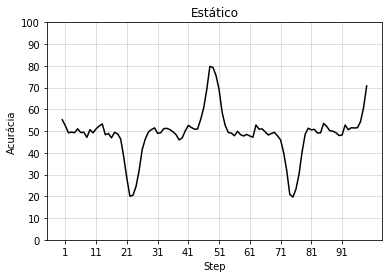

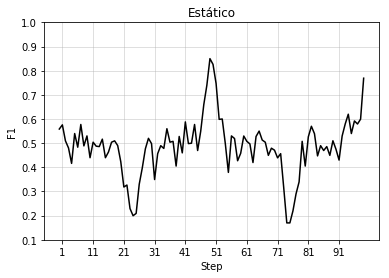




METHOD: Sliding lp as classifier
Execution time:  2.1453301166028518
Average MCC:  -0.017395239432875582
Average error: 50.3069
Average macro-F1: 0.4869940908984106
Average micro-F1: 0.49180000000000007
Acurácia Média:  49.6931
Desvio Padrão:  3.38924200817823
Variância:  11.486961390000001


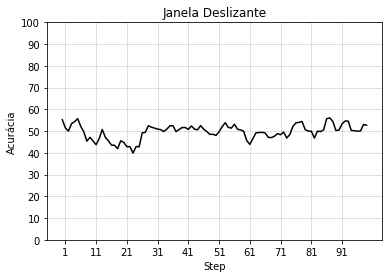

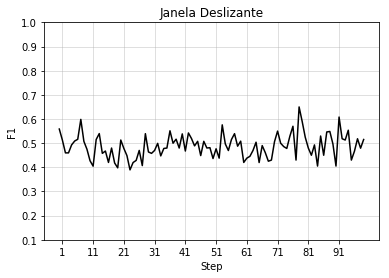




METHOD: Incremental lp as classifier
Execution time:  65.22820799353586
Average MCC:  -0.026360683194992608
Average error: 51.166199999999996
Average macro-F1: 0.48413608766762145
Average micro-F1: 0.48669999999999997
Acurácia Média:  48.833800000000004
Desvio Padrão:  10.57452994510867
Variância:  111.82068355999998


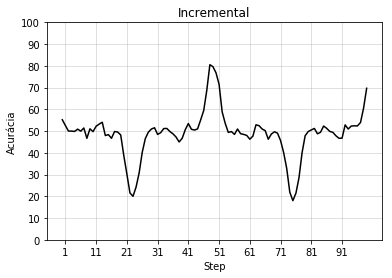

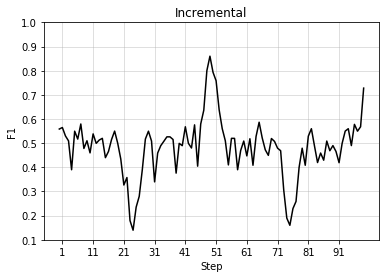




METHOD: lp as classifier and kde as core support extraction with cutting data method
Execution time:  26.220932095035153
Average MCC:  -0.00717664753637196
Average error: 50.218599999999995
Average macro-F1: 0.4921862340187328
Average micro-F1: 0.4958000000000001
Acurácia Média:  49.781400000000005
Desvio Padrão:  3.341634336668212
Variância:  11.166520040000002


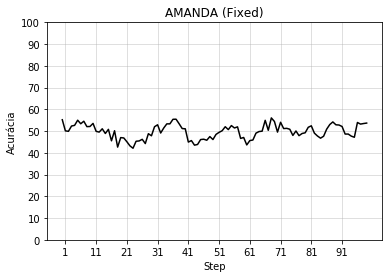

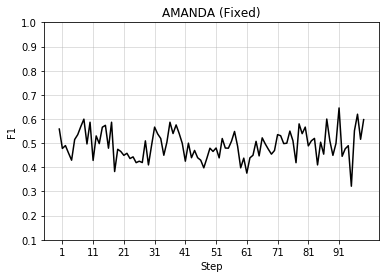




METHOD: lp as classifier and kde and Hellinger distance as dynamic CSE
AMANDA-DCP Hellinger | Mean keeping percentage=0.17 | Std keeping percentage=0.07
Execution time:  26.47275456858563
Average MCC:  0.002162564174719347
Average error: 49.993599999999994
Average macro-F1: 0.4968150075514039
Average micro-F1: 0.5002999999999999
Acurácia Média:  50.006400000000006
Desvio Padrão:  3.116259141984183
Variância:  9.711071039999997


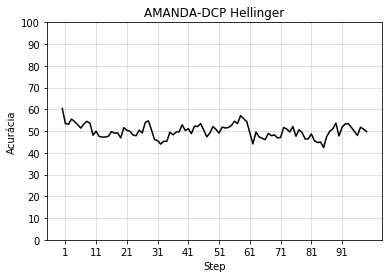

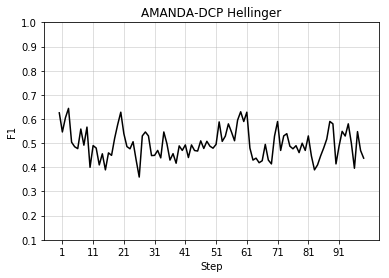




METHOD: lp as classifier and kde and Hellinger2 distance as dynamic CSE
AMANDA-DCP Hellinger2 | Mean keeping percentage=0.30 | Std keeping percentage=0.20
Execution time:  27.274489911121094
Average MCC:  0.0027012416667057653
Average error: 49.7826
Average macro-F1: 0.49698262453723463
Average micro-F1: 0.5012
Acurácia Média:  50.2174
Desvio Padrão:  3.2608335192094677
Variância:  10.633035240000002


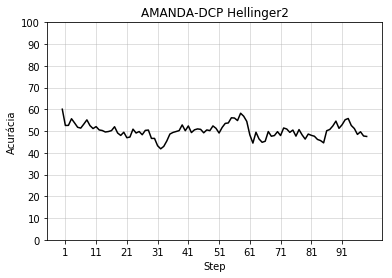

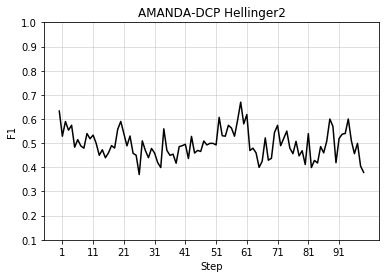




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = -1.000 | Mean keeping percentage=0.24 | Std keeping percentage=0.14
Execution time:  27.262155033180704
Average MCC:  0.012471297433464822
Average error: 49.806400000000004
Average macro-F1: 0.5020032560482663
Average micro-F1: 0.5057
Acurácia Média:  50.193599999999996
Desvio Padrão:  3.3106508483982426
Variância:  10.960409040000004


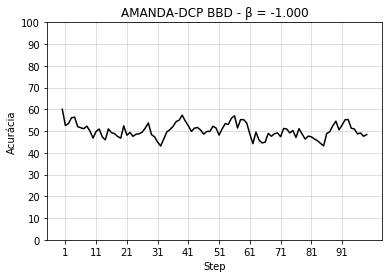

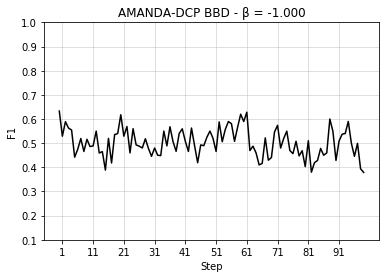

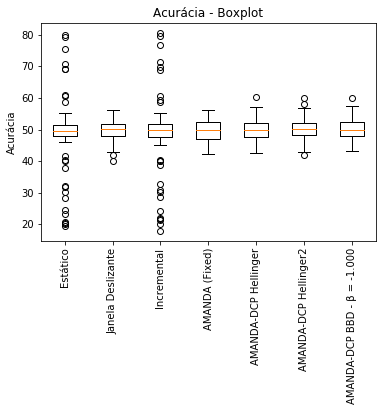

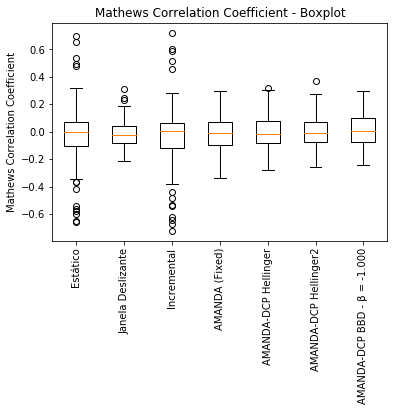

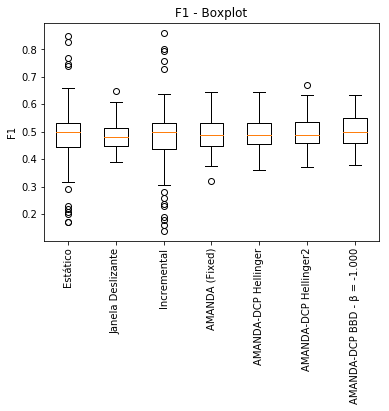

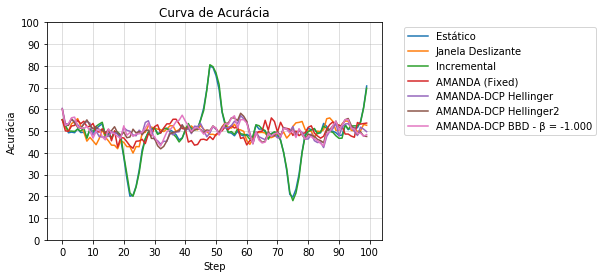

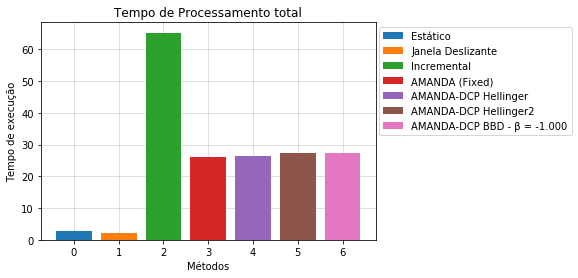

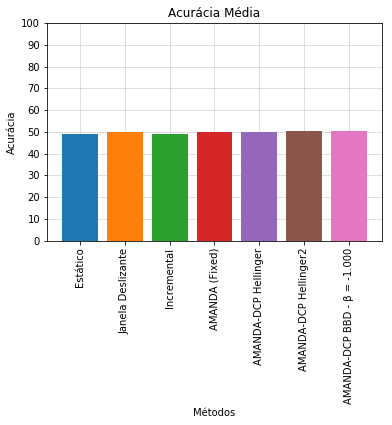

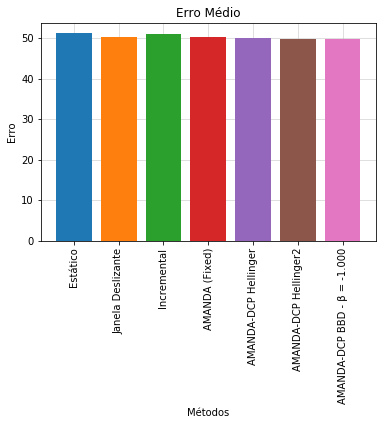

Pos 5 - Redução do Erro (Janela Deslizante):1.83262703181226
Pos 6 - Redução do Erro (Incremental):0.07172307515759341
Pos 4 - Redução do Erro (AMANDA (Fixed)):2.013574104281263
Pos 3 - Redução do Erro (AMANDA-DCP Hellinger):2.474651016008604
Pos 1 - Redução do Erro (AMANDA-DCP Hellinger2):2.9070386976728892
Pos 2 - Redução do Erro (AMANDA-DCP BBD - β = -1.000):2.858267006565728


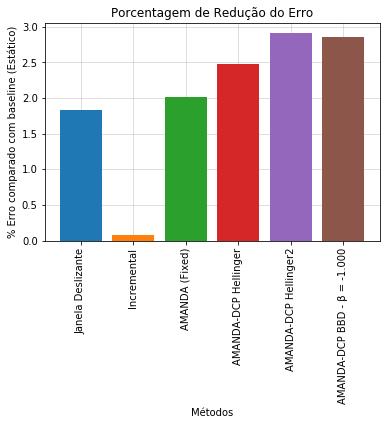

In [1]:
%matplotlib inline
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[4])

import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None, distanceMetric=None, beta=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K
        self.distanceMetric = distanceMetric
        self.beta = beta


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ predictions[i::steps] for i in range(steps) ]
    
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 100
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = True
    isImbalanced = False
    externalResults = []
    
    # Load dataset
    dataValues, dataLabels, description = setup.loadCheckerBoard(path, sep)
    
    # 20% of initial labeled data
    labeledData = int(0.05*len(dataLabels))

    # Static SSL
    experiments[0] = Experiment(static_classifier, 3, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 3, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 3, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 3, 0.65, "kde", sslClassifier)

    # Proposed method 2 (AMANDA - DCP Original)
    experiments[4] = Experiment(amanda_dynamic, 8, None, "kde", sslClassifier, 'Hellinger')
    
    # Proposed method 3 (AMANDA - DCP Hellinger2)
    experiments[5] = Experiment(amanda_dynamic, 12, None, "kde", sslClassifier, 'Hellinger2')                         
    
    # Proposed method 4 (AMANDA - DCP BBD)
    lastIndex = list(experiments.keys())[-1]
    betas = [-1]
    bestK = [12]
    for i in range(len(betas)):
        experiments[lastIndex+1+i] = Experiment(amanda_dynamic, bestK[i], None, "kde", sslClassifier, 'BBD', beta=betas[i])

    # Proposed method 5 (AMANDA - DCP HDDDM)
    #experiments[17] = Experiment(amanda_dynamic, 10, None, "kde", sslClassifier, 'HDDDM')

    
    # COMPOSE GMM (Python version)
    #experiments[5] = Experiment(compose_gmm_version, 5)
    
    # levelIw matlab results
    #predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, '1CHT', steps)
    #externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw, "accuracies":originalAccsLevelIw, "time":timeLevelIw})
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()